In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold


from src.data.data_fetcher import get_all_features, get_raw_data
from src.features.feature_engineering import prepare_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data, fetch_preprocessed_uniform_data
pd.set_option('display.max_columns', 200)


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\gunna\Documents\Maskinlæring\Prosjekt\power-predictor\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [12]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()



X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
X_test_estimated_a_processed, X_test_estimated_b_processed, X_test_estimated_c_processed = get_preprocessed_test_data()



x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)



x_whole.head()


# y_train_obs_combined.shape


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,cloud_ratio,sun_addition,is_freezing,is_snow,is_rain
0,8.950,1.24900,0.00000,0.000000,523.099976,1.0,282.424988,0.000000,0.000000,0.000000,0.000000,49.000000,0.0,1.0,1018.450012,0.0,0.0,1005.674988,1011.775024,0.0,0.0,96.224998,1017.900024,13.285750,0.00,283.075012,59.175003,14021.924805,1.40,1.350,0.475,0.0,1,0,0,-0.126528,-0.991963,0.000000,1.000000,0.000000,0.000000,0.000000,0.828052,0.000000,0,0,0
1,4.200,1.25200,0.00000,0.000000,725.250000,0.0,271.299988,0.000000,0.000000,0.000000,0.000000,71.725006,0.0,1.0,991.549988,0.0,0.0,978.549988,984.674988,0.0,0.0,75.025002,990.799988,65.990753,0.00,275.600006,92.550003,34210.601562,6.40,5.825,2.650,0.0,0,1,0,0.635068,0.772456,0.707107,0.707107,0.000000,0.000000,0.000000,0.774987,0.000000,0,0,0
2,7.575,1.23975,0.00000,0.000000,1040.349976,1.0,279.774994,0.000000,0.000000,0.000000,0.000000,79.824997,0.0,1.0,1000.574951,0.0,0.0,988.049988,994.099976,0.0,0.0,82.425003,1000.150024,72.135750,0.00,283.500000,99.324997,25742.375000,1.20,-1.075,0.500,0.0,1,0,0,-0.928839,0.370483,0.707107,0.707107,0.000000,0.000000,0.000000,0.803675,0.000000,0,0,0
3,8.525,1.23250,406653.21875,66.824997,2028.300049,0.0,281.750000,17.174999,85737.351562,0.000000,274.900024,100.000000,1.0,0.0,1011.275024,0.0,0.0,998.400024,1004.425049,0.0,0.0,80.449997,1010.474976,244.041748,0.05,283.875000,100.000000,14223.199219,2.15,-2.150,-0.425,0.0,0,1,0,-0.997559,0.069828,-0.707107,-0.707107,0.000000,0.116874,0.000676,1.000000,17.174999,0,0,0
4,3.900,1.26975,228987.65625,97.699997,3737.000000,0.0,270.299988,58.224998,145324.328125,16.700001,31096.449219,63.924999,1.0,0.0,1000.400024,0.0,0.0,987.174988,993.375000,0.0,0.0,75.400002,999.574951,140.643494,0.00,274.250000,76.925003,50366.976562,1.75,-1.725,0.175,0.0,0,1,0,-0.922329,0.386405,0.866025,-0.500000,972.357544,0.151533,0.135800,0.831004,74.925003,0,0,0


In [13]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

reg_models = []


for train_index, test_index in kf.split(x_whole):

    reg = xgb.XGBRegressor(n_estimators=1000000,
                       early_stopping_rounds=50,
                       learning_rate= 0.001,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 1.0,
                       gamma = 0,
                       min_child_weight=0,
                       max_depth=9)
    

    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]
    
    reg.fit(X_train, y_train,
            eval_set=[(X_val_est_combined, y_val_est_combined)],
            verbose=100)
    
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")




[0]	validation_0-mae:381.25160	validation_1-mae:433.64841
[100]	validation_0-mae:348.38380	validation_1-mae:395.40430
[200]	validation_0-mae:318.76937	validation_1-mae:361.32146
[300]	validation_0-mae:292.18108	validation_1-mae:330.97035
[400]	validation_0-mae:268.61175	validation_1-mae:304.07305
[500]	validation_0-mae:247.55905	validation_1-mae:280.12015
[600]	validation_0-mae:228.64418	validation_1-mae:258.81206
[700]	validation_0-mae:211.74446	validation_1-mae:240.01232
[800]	validation_0-mae:196.53963	validation_1-mae:223.54745
[900]	validation_0-mae:183.17905	validation_1-mae:208.96357
[1000]	validation_0-mae:171.01107	validation_1-mae:195.90320
[1100]	validation_0-mae:160.02527	validation_1-mae:184.28243
[1200]	validation_0-mae:150.17837	validation_1-mae:173.98998
[1300]	validation_0-mae:141.45791	validation_1-mae:164.83432
[1400]	validation_0-mae:133.66526	validation_1-mae:156.67618
[1500]	validation_0-mae:126.68341	validation_1-mae:149.45368
[1600]	validation_0-mae:120.38834	va

In [14]:
# reg = xgb.XGBRegressor(n_estimators=28000,
#                        learning_rate= 0.01,
#                        objective="reg:linear",
#                        eval_metric="mae",
#                        sub_sample = 0.9,
#                        colsample_bytree = 1.0,
#                        gamma = 0,
#                        min_child_weight=0,
#                        max_depth=9)


# reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train)],
#             verbose=100)

In [15]:
# # Predict on the cleaned validation set
# from src.features.preprocess_data import get_final_prediction


# y_val_pred_est_a = reg.predict(X_test_estimated_a_processed, reg_models)
# y_val_pred_est_b = reg.predict(X_test_estimated_b_processed, reg_models)
# y_val_pred_est_c = reg.predict(X_test_estimated_c_processed, reg_models)

# # Combine the predictions into a single array
# y_pred_test_est_combined = get_final_prediction(y_val_pred_est_a, y_val_pred_est_b, y_val_pred_est_c)
# y_pred_test_est_combined.shape

# from src.models.saving import save_predictions


# save_predictions(y_pred_test_est_combined, 'gunnar xgboost folds=1')

<Figure size 10000x10000 with 0 Axes>

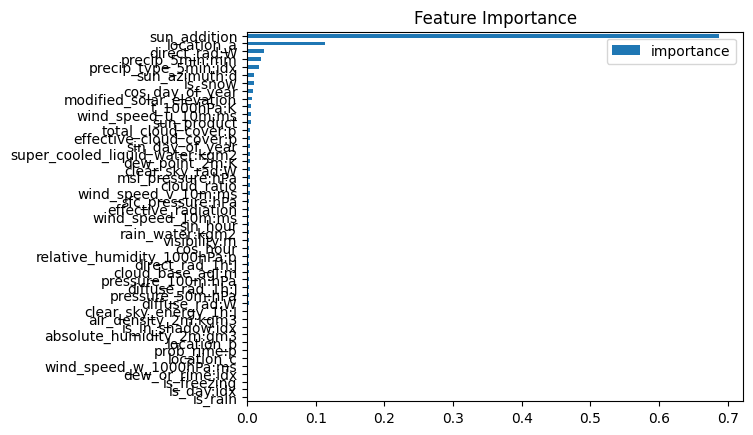

In [16]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [17]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        new_results = model.predict(x_values)
        results += new_results
    

    results = results / len(models)



    return results

        

In [18]:
results = multi_predict(X_test_estimated_a_processed, reg_models)

In [19]:
y_pred_val_obs_combined = multi_predict(X_val_obs_combined, reg_models)
y_pred_val_est_combined = multi_predict(X_val_est_combined, reg_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


MAE on validation observed data:  31.620670840874634
MAE on validation estimated data:  64.15730752869206


In [20]:
# Predict on the cleaned validation set
from src.features.preprocess_data import get_final_prediction


y_val_pred_est_a = multi_predict(X_test_estimated_a_processed, reg_models)
y_val_pred_est_b = multi_predict(X_test_estimated_b_processed, reg_models)
y_val_pred_est_c = multi_predict(X_test_estimated_c_processed, reg_models)

# Combine the predictions into a single array
y_pred_test_est_combined = get_final_prediction(y_val_pred_est_a, y_val_pred_est_b, y_val_pred_est_c)
y_pred_test_est_combined.shape

from src.models.saving import save_predictions


save_predictions(y_pred_test_est_combined, 'gunnar xgboost both observed and est')


   id  prediction
0   0    7.731390
1   1    1.021590
2   2    2.279550
3   3    1.060972
4   4  192.052811
